In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
!unzip -q aerial-cactus-identification/train.zip

In [4]:
!unzip -q aerial-cactus-identification/test.zip

In [5]:
len(os.listdir('train'))

17500

In [6]:
df=pd.read_csv('aerial-cactus-identification/train.csv')

In [7]:
image=cv2.imread('train/'+df['id'][0])
image.shape

(32, 32, 3)

In [8]:
df.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [9]:
idg=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,validation_split=.1)

In [10]:
df.iloc[1,0]

'000c8a36845c0208e833c79c1bffedd1.jpg'

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomTranslation(0.14,0.14),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ]
)

2023-01-30 21:23:32.729241: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
inputs=tf.keras.Input(shape=(32,32,3))
input=data_augmentation(inputs)
conv1=tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(input)
conv1=tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(conv1)
pool=tf.keras.layers.MaxPool2D(2)(conv1)
conv2=tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(pool)
conv2=tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation='relu',padding='same')(conv2)
pool2=tf.keras.layers.MaxPool2D(2)(conv2)
flatten=tf.keras.layers.Flatten()(pool2)
dense1=tf.keras.layers.Dense(120,activation='relu')(flatten)
norm1=tf.keras.layers.BatchNormalization(trainable=False)(dense1)
drop1=tf.keras.layers.Dropout(.3)(norm1)
# dense1=tf.keras.layers.Dense(120,activation='relu')(drop1)
# norm1=tf.keras.layers.BatchNormalization(trainable=False)(dense1)
# drop1=tf.keras.layers.Dropout(.3)(norm1)
dense2=tf.keras.layers.Dense(120,activation='relu')(drop1)

Output=tf.keras.layers.Dense(1,activation='sigmoid')(dense2)
model=tf.keras.models.Model(inputs=inputs,outputs=Output)
model.summary()
# tf.keras.layers.I

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        4624  

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        4624  

In [16]:
df['has_cactus']=df['has_cactus'].astype(str)

In [18]:
df

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [19]:
batch_size = 32
x_col, y_col = 'id', 'has_cactus'
class_mode = 'binary'
target_size=(32,32)

train_gen = idg.flow_from_dataframe(df,
                                            'train',
                                            x_col=x_col,
                                            y_col=y_col,
                                            class_mode=class_mode,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                    subset='training'
                                            )

val_gen = idg.flow_from_dataframe(df,
                                        'train',
                                        x_col=x_col,
                                        y_col=y_col,
                                        class_mode=class_mode,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        subset='validation'
                                        )

Found 15750 validated image filenames belonging to 2 classes.
Found 1750 validated image filenames belonging to 2 classes.


In [20]:
# del model

In [21]:
def step_decay(epoch):
    initial_rate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_rate * math.pow(drop, math.floor((epoch) / epochs_drop))
    
    return lrate

In [22]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

callbacks = [lrate, es]

In [23]:
import math

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.binary_crossentropy,metrics=['acc'])

In [25]:
history=model.fit(train_gen,validation_data=val_gen,epochs=50,batch_size=128,callbacks=callbacks)

2023-01-30 21:23:34.242504: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
493/493 [==============================] - 35s 68ms/step - loss: 0.3904 - acc: 0.8315 - val_loss: 0.2993 - val_acc: 0.8651
Epoch 2/50
493/493 [==============================] - 32s 64ms/step - loss: 0.2558 - acc: 0.8952 - val_loss: 0.2206 - val_acc: 0.8874
Epoch 3/50
493/493 [==============================] - 30s 60ms/step - loss: 0.2078 - acc: 0.9172 - val_loss: 0.1620 - val_acc: 0.9171
Epoch 4/50
493/493 [==============================] - 30s 62ms/step - loss: 0.1619 - acc: 0.9381 - val_loss: 0.3000 - val_acc: 0.8463
Epoch 5/50
493/493 [==============================] - 31s 63ms/step - loss: 0.1355 - acc: 0.9497 - val_loss: 0.1257 - val_acc: 0.9480
Epoch 6/50
493/493 [==============================] - 31s 63ms/step - loss: 0.1178 - acc: 0.9549 - val_loss: 0.0634 - val_acc: 0.9737
Epoch 7/50
493/493 [==============================] - 31s 62ms/step - loss: 0.1110 - acc: 0.9592 - val_loss: 0.0776 - val_acc: 0.9691
Epoch 8/50
493/493 [==============================] - 31s 63ms

In [26]:
# del model

<AxesSubplot:>

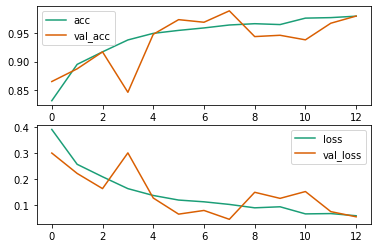

In [27]:

import seaborn as sns
sns.set_palette('Dark2')
fig,ax = plt.subplots(2, 1)

plot_acc = pd.DataFrame({'acc': history.history['acc'],
                         'val_acc': history.history['val_acc']})

plot_loss = pd.DataFrame({'loss': history.history['loss'],
                          'val_loss': history.history['val_loss']})

plot_acc.plot(ax=ax[0])
plot_loss.plot(ax=ax[1])



In [28]:
import tqdm
def predict(model, sub_df):
    pred = np.empty((sub_df.shape[0],))
    for n in range(sub_df.shape[0]):
        image = np.array(Image.open('test/' + sub_df.id[n]))
        pred[n] = model.predict(image.reshape((1, 32, 32, 3))/255.0)[0]
    
    sub_df['has_cactus'] = pred
    return sub_df

In [30]:
sub_df = pd.read_csv('aerial-cactus-identification/sample_submission.csv')
predictions = predict(model, sub_df)

In [31]:
!rm -r *

In [32]:
predictions.to_csv('result.csv', header=True, index=False)